In [9]:
import numpy as np
np.fft.fft([1, 2, 3, 4])

array([10.+0.j, -2.+2.j, -2.+0.j, -2.-2.j])

# Project 1: Where are My Glasses?
## Due: 2020-03-06

![blurred image](https:/github.com/dbindel/cs4220-s20/raw/master/hw/code/proj1/data/blurry.png)

The image above is a blurred version of a picture that
I took at the local SPCA.  As we will see, a naive approach to
de-blurring produces garbage, a characteristic feature of *ill-posed*
problems.  In order to reconstruct the image, we need to *regularize*
the reconstruction, just as we would regularize an ill-posed least squares
problem.  We will use Tikhonov regularization, as described in class.
However, this involves choosing the value of a
regularization parameter.  Your mission is to investigate the dependence
on the parameter, and to investigate three approaches to
choosing this parameter (mostly) automatically.

You are given the file `blurry.png` (the blurred image shown above).
You are responsible for the following deliverables, which can either
by submitted as a Jupyter notebook (recommended) or in standalone code:

- Codes to compute "optimal" values of the regularization
  parameter $\lambda$ via the discrepancy principle, the L-curve,
  and generalized cross-validation.
- A report that addresses the questions posed in the rest of this
  prompt.

This project is inspired by the project on image deblurring by James
G. Nagy and Dianne P. O'Leary 
([Image Deblurring: I Can See Clearly Now](http://ieeexplore.ieee.org/document/1196312/))
in _Computing in Science and Engineering_; Project: Vol. 5,
No. 3, May/June 2003, pp. 82-85; Solution: Vol. 5, No. 4, July/August
2003).  Other useful references include:

- Hansen, Nagy, O'Leary.  [*Deblurring Images: Matrices, Spectra, and Filtering*](http://epubs.siam.org/doi/book/10.1137/1.9780898718874), SIAM 2006.
- Hansen and O'Leary.  ["The Use of the L-Curve in the Regularization of Discrete Ill-Posed Problems"](http://epubs.siam.org/doi/abs/10.1137/0914086) in *SIAM J. Sci. Comput.*, Vol 14, No. 6, November 1993.
- Golub, Heath, and Wahba. ["Generalized Cross-Validation as a Method for Choosing a Good Ridge Parameter"](http://www.stat.wisc.edu/~wahba/ftp1/oldie/golub.heath.wahba.pdf) in *Technometrics*, Vol. 21, No. 2, May 1979.
- Golub and von Matt. ["Generalized Cross-Validation for Large-Scale Problems"](https://www.jstor.org/stable/pdf/1390722.pdf) in *Journal of Computational and Graphical Statistics*, Vol. 6, No. 1, March 1997.
-  Morozov.  [*Methods for Solving Incorrectly Posed Problems*](https://link.springer.com/book/10.1007%2F978-1-4612-5280-1), Springer-Verlag, 1984.

It should be possible to do this assignment based only on ideas
presented in this prompt and in the lectures.  However,
you are always welcome to use any ideas or code you find in the
literature, including in the references noted above, provided you
give an appropriate citation.

## Python Setup

The Python version of this project uses the Jupyter notebook interface for convenience, run using Python 3.  You are allowed to submit a standalone code file if you would prefer not to use Jupyter.  To run the notebook, you will need to make sure that a few packages are installed:

- [FileIO](https://github.com/JuliaIO/FileIO.jl): The FileIO library provides extensible support for loading different types of files; we use it to work with PNG files.
- [Images](https://juliaimages.org/latest/): The Images package provides various tools for working with images.
- [FFTW](https://github.com/JuliaMath/FFTW.jl): The FFTW package provides Fourier transform tools.
- [Colors](https://github.com/JuliaGraphics/Colors.jl): Manipulates different color spaces
- [Roots](https://github.com/JuliaMath/Roots.jl): Solve one-dimensional nonlinear equations
- [Plots](http://docs.juliaplots.org/latest/): Create plots in Julia

You will also want to install the [ImageMagick](https://github.com/JuliaIO/ImageMagick.jl) or [QuartzImageIO](https://github.com/JuliaIO/QuartzImageIO.jl) (on Mac) to work with FileIO to load images.  You do not need to include these packages directly with `using`, but they will be loaded by the FileIO library.

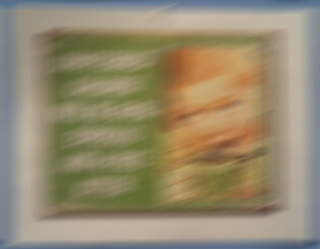

In [63]:
from PIL import Image
import requests
from IPython.display import display
from io import BytesIO
response = requests.get("https://github.com/dbindel/cs4220-s20/raw/master/hw/code/proj1/data/blurry.png")
blurry_img = Image.open(BytesIO(response.content))
display(blurry_img)

## Image array manipulation

Images are represented in Pillow, a Python imaging library, as three-dimensional arrays of color values.  In the default representation of the PNG file that we downloaded, each pixel color is represented by 24 bits, with 8 bits each for the red, green, and blue intensity values (RGB).  Each 8 bit number is represented as a fixed-point number with values ranging from 0.0 = 0/255 to 1.0 = 255/255 (a `Normed{Uint8,8}` type in Julia).

In [42]:
type(blurry_img)

PIL.PngImagePlugin.PngImageFile

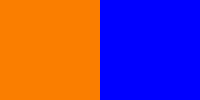

array([[250, 250, 250, ...,   0,   0,   0],
       [250, 250, 250, ...,   0,   0,   0],
       [250, 250, 250, ...,   0,   0,   0],
       ...,
       [250, 250, 250, ...,   0,   0,   0],
       [250, 250, 250, ...,   0,   0,   0],
       [250, 250, 250, ...,   0,   0,   0]], dtype=uint8)

In [59]:
import numpy as np
from PIL import Image
from IPython.display import display

array = np.zeros([100, 200, 3], dtype=np.uint8)
array[:,:100] = [250, 126, 0] #Orange left side
array[:,100:] = [0, 0, 255]   #Blue right side#

img = Image.fromarray(array)
display(img)

array[:, :,0]
#array = np.zeros([20, 20, 3], dtype = np.uint8)
#img2 = Image.fromarray(array)
#display(img2)

The picture was generated by a blurring operation that works on each color plane independently.  To deblur, we want to work on the arrays for one color plane at a time.  Therefore, we will manipulate the data in terms of three floating-point arrays (one each for the red, green, and blue levels), which we construct via the `channelview` function.  The `colorview` function maps these floating point arrays back to a viewable image.  We define a convenience function `arrays_to_img` that does this conversion and makes sure that all the entries of the arrays are clipped back to the interval from 0 to 1.

npixels 79680


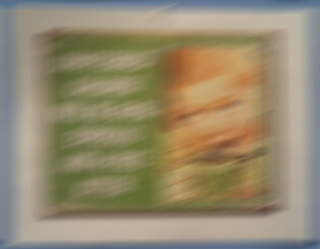

In [77]:
# Convenience function to count pixels
def img_rgb_pixels(V):
    return V.shape[0]*V.shape[1]

# Convert 3-array representation to ordinary colorview representation
def arrays_to_img(V):
    img = Image.fromarray(V)
    return img

# Compute the 3-array representation of the blurry image and illustrate the above helpers
blurry_rgb = np.array(blurry_img)
print("npixels " + str(img_rgb_pixels(blurry_rgb)))
arrays_to_img(blurry_rgb)

## Blurring, convolution, and Fourier transforms

The image was blurred by *convolving* with a blurring kernel and then rounding the result.  That is, the map from the original pixels $x_{ij}$ to the blurred pixels $y_{ij}$ is given by
$$
  y_{ij} = (k*x)_{ij} = \sum_{k,l} k_{kl} x_{i-k,j-l}
$$
The kernel is in the `K.mat` file in the `proj1/data` subdirectory in the repository, and corresponds to the type of blurring that one sees with motion blur: each pixel in the output is the average of a few pixels along a diagonal line in the image.

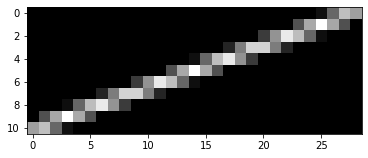

In [110]:
import matplotlib.pyplot as plt

K = np.loadtxt("../data/Km.txt")

plt.imshow(K, cmap="gray")
plt.show()

The function represented by the matrix $K$ is sometimes called the *point spread function* or PSF.  It turns out that the convolution operation $k*x$ -- which we will generally denote as a linear operation $H$ that maps images to images -- can be done very quickly via Fourier transforms: $(\hat{k*x})_{ij} = \hat{k}_{ij} \hat{x}_{ij} = s_{ij} \hat{x}_{ij}$.  Therefore, we will want to keep around a 2D Fourier transform of the (padded) kernel matrix for fast operations with $H$.

0.1486028500432828


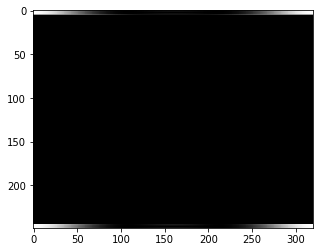

In [212]:
def get_psf_fft(img, K):
    K = np.array(K)
    aimg = np.array(img)
    h, w, k = aimg.shape 
    center = (np.array(K.shape) +1)/2
    PSF = np.zeros((h, w))
    PSF[0:K.shape[0], 0:K.shape[1]] = K
    x = np.array(1 - center).astype(int)
    r = np.roll(PSF, x[0], axis=0)
    r = np.roll(r, x[1], axis=1)
    print(np.linalg.norm(r))
    PSFfft = np.fft.fft(r)
    return np.array(PSFfft)

s = np.absolute(get_psf_fft(blurry_img, K))
plt.imshow(s, cmap="gray")
plt.show()

In [202]:
a, b = (np.array([[1, 2], [3, 4]])).shape

m = np.array([[1, 2], [3, 4]])
np.array(m.shape) +1
X = np.array([[1, 2], [3, 4]])
X.shape[1]

x = np.array([1+2j, 2+3j])
np.absolute(x)

x = np.array([i for i in range(1, 17)]).reshape(4, 4)
np.roll(x, 1, 1)

array([[ 4,  1,  2,  3],
       [ 8,  5,  6,  7],
       [12,  9, 10, 11],
       [16, 13, 14, 15]])